### Load Python Package

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime
from datetime import date
import seaborn as sns
from shapely.geometry import Point, MultiPolygon
import geojson
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy as sp
from statsmodels.graphics import utils
import statsmodels.stats.api as sms
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
%matplotlib inline

### Definition of Function 

#### Function for Calculating distance between two points using Longitude & Latitude.
> * the direct distance of two GPS location, taking into account that the earth is round.  

In [27]:
def haversine_array(latitude1, longitude1, latitude2, longitude2):
    latitude1, longitude1, latitude2, longitude2 = map(np.radians, (latitude1, longitude1, latitude2, longitude2))
    # The average radius of the earth
    # in km
    AVG_EARTH_RADIUS = 6371
    lat = latitude2 - latitude1
    lng = longitude2 - longitude1
    d = np.sin(lat * 0.5) ** 2 + np.cos(latitude1) * np.cos(latitude2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

 #### Function for Calculating each coordinate of distance.  
> * the usual L1 distance, here the haversine distance is used to calculate each coordinate of distance.  

In [28]:
def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

 #### Function for The direction of the trip
> Using radian as unit.

In [29]:
def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

#### Function for Rest day

In [30]:
def restday(yr,month,day,holidays):
    '''
    Output:
        is_rest: a list of Boolean variable indicating if the sample occurred in the rest day.
        is_weekend: a list of Boolean variable indicating if the sample occurred in the weekend.
    '''
    is_rest    = [None]*len(yr)
    is_weekend = [None]*len(yr)
    i=0
    for yy,mm,dd in zip(yr,month,day):        
        is_weekend[i] = date(yy,mm,dd).isoweekday() in (6,7)
        is_rest[i]    = is_weekend[i] or date(yy,mm,dd) in holidays 
        i+=1
    return is_rest,is_weekend

### Load Training dataet

In [128]:
train = pd.read_csv('./data/transformed_train.csv')
print ("Training data has {} rows and {} columns".format(train.shape[0],train.shape[1]))
print ("data : {}".format(train.shape[0]))
print ("Feature : {}".format(train.shape[1]))

Training data has 701778 rows and 32 columns
data : 701778
Feature : 32


In [129]:
train.drop(['minute','month','day'],axis = 1,inplace = True)

In [213]:
train.shape

(701778, 29)

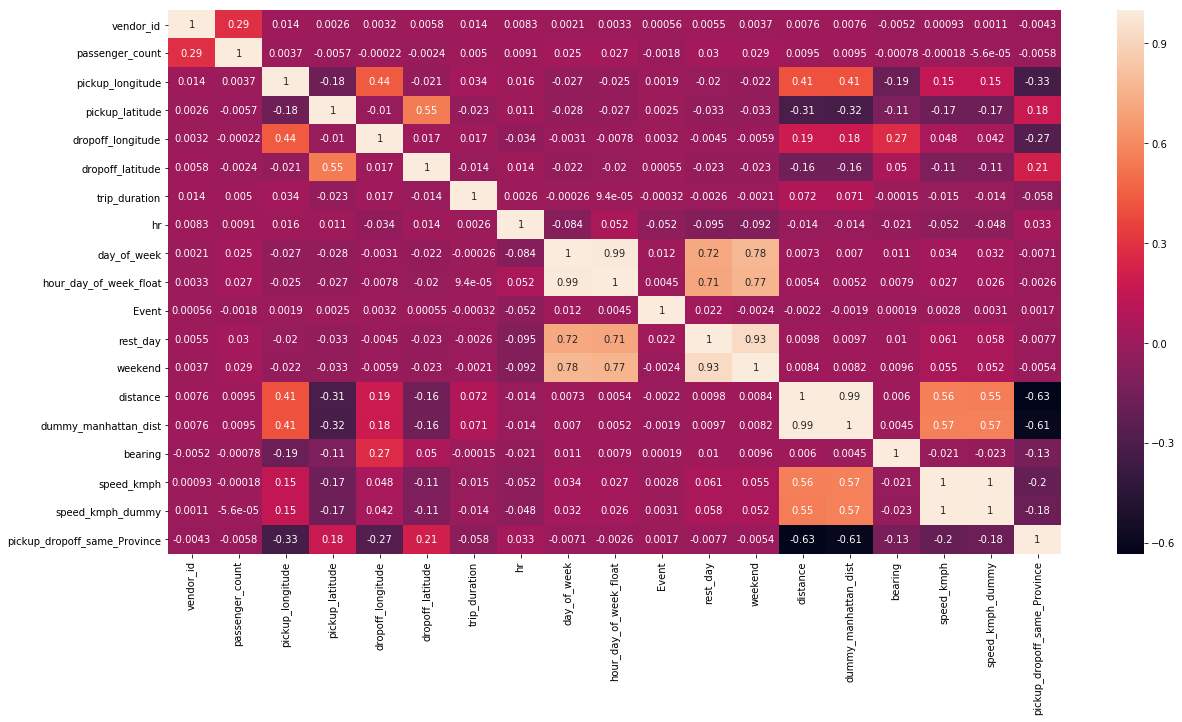

In [382]:
plt.figure(figsize=(20,10))
sns.heatmap(train.corr(),annot = True)

In [433]:
firstIs = 'I(np.log(trip_duration)) ~ '

identicalVar = 'id'

dependentVar = 'trip_duration'
dateTimeVarList = ['pickup_datetime','dropoff_datetime']
dateVar = 'pickup_date'
timeVar = 'pickup_time'

notUsed = ['year','minute']

categoryVarList_1st = ['pickup_Province', 'dropoff_Province',
'pickup_dropoff_same_Province', 'pickup_Airport', 'dropoff_Airport']
categoryVarList_2nd = ['rest_day','weekend', 'Event']
categoryVarList_3rd = ['vendor_id', 'store_and_fwd_flag'] 
for w in categoryVarList_1st+categoryVarList_2nd+categoryVarList_3rd:
    firstIs += 'C({})+'.format(w)
posVarList = [ 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude']
for i in posVarList:
    firstIs += '{}+'.format(i)

realVarList_1st = ['dummy_manhattan_dist','distance']
for i in realVarList_1st:
    firstIs += 'scale(I(np.log({}+0.1)))+'.format(i)

realVarList_2nd = 'scale(bearing)'
firstIs = firstIs + realVarList_2nd
#realVarList_2nd = ['hour_day_of_week_float']
#firstIs = firstIs+'+' + '+'.join(realVarList_2nd) + '+'
realVarList_3rd =['scale(day_of_week)','scale(hr)']
firstIs = firstIs+ '+' + '*'.join(realVarList_3rd)+ '+'

realVarList_4th = 'passenger_count'
firstIs = firstIs + realVarList_4th + '+'
someProblem = ['speed_kmph','speed_kmph_dummy']
# 1
'''
I(np.log(trip_duration)) ~ C(pickup_Province)*C(dropoff_Province)+C(pickup_dropoff_same_Province)+C(pickup_Airport)+C(dropoff_Airport)+C(rest_day)+C(weekend)+C(Event)+C(vendor_id)+C(store_and_fwd_flag)+pickup_longitude+pickup_latitude+dropoff_longitude+dropoff_latitude+I(np.log(dummy_manhattan_dist+1))+I(np.log(distance+1))+bearing+hour_day_of_week_float+day_of_week+hr+passenger_count+
'''
formulaIs1 = firstIs + '0'
print (formulaIs1)
cs = categoryVarList_1st+categoryVarList_2nd+categoryVarList_3rd+realVarList_1st+realVarList_3rd+[realVarList_4th]

I(np.log(trip_duration)) ~ C(pickup_Province)+C(dropoff_Province)+C(pickup_dropoff_same_Province)+C(pickup_Airport)+C(dropoff_Airport)+C(rest_day)+C(weekend)+C(Event)+C(vendor_id)+C(store_and_fwd_flag)+pickup_longitude+pickup_latitude+dropoff_longitude+dropoff_latitude+scale(I(np.log(dummy_manhattan_dist+0.1)))+scale(I(np.log(distance+0.1)))+scale(bearing)+scale(day_of_week)*scale(hr)+passenger_count+0


In [434]:
model = sm.OLS.from_formula(formulaIs1,data = train)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     I(np.log(trip_duration))   R-squared:                       0.611
Model:                                  OLS   Adj. R-squared:                  0.611
Method:                       Least Squares   F-statistic:                 3.559e+04
Date:                      Sun, 22 Oct 2017   Prob (F-statistic):               0.00
Time:                              15:15:47   Log-Likelihood:            -4.9890e+05
No. Observations:                    701778   AIC:                         9.979e+05
Df Residuals:                        701746   BIC:                         9.982e+05
Df Model:                                31                                         
Covariance Type:                  nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
C(pickup_Province)[Bronx]                       16.5764      1.851      8.956      0.000      12.949      20.204
C(pickup_Province)[Brooklyn]                    16.4061      1.850      8.866      0.000      12.779      20.033
C(pickup_Province)[Manhattan]                   16.4796      1.851      8.902      0.000      12.851      20.108
C(pickup_Province)[Queens]                      16.3373      1.849      8.835      0.000      12.713      19.961
C(pickup_Province)[Staten Island]               18.2758      1.854      9.859      0.000      14.642      21.909
C(pickup_Province)[outward]                     16.2709      1.850      8.794      0.000      12.645      19.897
C(dropoff_Province)[T.Brooklyn]                 -0.0622      0.009     -7.069      0.000      -0.079      -0.045
C(dropoff_Province)[T.Manhattan]                 0.0703      0.008      8.422      0.000       0.054       0.087
C(dropoff_Province)[T.Queens]                   -0.0113      0.009     -1.299      0.194      -0.028       0.006
C(dropoff_Province)[T.Staten Island]            -0.4361      0.040    -10.895      0.000      -0.515      -0.358
C(dropoff_Province)[T.outward]                  -0.2319      0.013    -18.149      0.000      -0.257      -0.207
C(pickup_dropoff_same_Province)[T.1]            -0.0331      0.003    -10.560      0.000      -0.039      -0.027
C(pickup_Airport)[T.L]                           0.0999      0.008     13.036      0.000       0.085       0.115
C(pickup_Airport)[T.N]                           0.0902      0.007     12.524      0.000       0.076       0.104
C(dropoff_Airport)[T.L]                          0.2321      0.011     20.713      0.000       0.210       0.254
C(dropoff_Airport)[T.N]                          0.2281      0.010     22.397      0.000       0.208       0.248
C(rest_day)[T.True]                             -0.1256      0.003    -36.963      0.000      -0.132      -0.119
C(weekend)[T.True]                              -0.0255      0.004     -6.608      0.000      -0.033      -0.018
C(Event)[T.1.0]                                  0.0254      0.005      4.977      0.000       0.015       0.035
C(vendor_id)[T.2]                                0.0200      0.001     16.165      0.000       0.018       0.022
C(store_and_fwd_flag)[T.Y]                       0.0180      0.008      2.255      0.024       0.002       0.034
pickup_longitude                                 0.4025      0.027     14.672      0.000       0.349       0.456
pickup_latitude                                  0.3381      0.027     12.634      0.000       0.286       0.391
dropoff_longitude                               -0.9217      0.023    -40.580  

In [435]:
inf = result.get_influence()
hat = inf.hat_matrix_diag
print('hat.sum() =',hat.sum())
x_new = train[cs]
y_new = result.predict()

hat.sum() = 32.0


KeyError: "['scale(day_of_week)' 'scale(hr)'] not in index"

In [ ]:
x_new.tail()

In [ ]:
cooks_d2, pvals = inf.cooks_distance
fox_cr = 4 / (len(train['trip_duration']) - 2)
idx = np.where(cooks_d2 > fox_cr)[0]

ax = plt.subplot()
plt.scatter(y_new,train['trip_duration'])
plt.scatter(y_new[idx], train['trip_duration'][idx], s=300, c="r", alpha=0.5)
utils.annotate_axes(range(len(idx)), idx, 
                    list(zip(y_new[idx], train['trip_duration'][idx])), [(-20, 15)] * len(idx), size="small", ax=ax)
plt.show()
len(idx)

In [ ]:
train[:][]

In [ ]:
sm.stats.anova_lm(result,typ =2)

In [ ]:
sp.stats.probplot(result.resid, plot=plt)
plt.show()

In [ ]:
filter_X =train[:]
filter_X.drop(idx,0,inplace = True)
filter_X.tail()
print (train.shape)
print (filter_X.shape)

In [ ]:
modela = sm.OLS.from_formula(formulaIs1,data = filter_X)
resulta = modela.fit()
resulta.summary()

In [ ]:
filter_X.describe()

In [ ]:
filter_X = filter_X[:][ (filter_X['passenger_count']!=0) 
                       & (filter_X['dummy_manhattan_dist']!=0) 
                       & (filter_X['distance']!=0) 
                       & (filter_X['speed_kmph_dummy']<100)]
filter_X.tail()

In [ ]:
modela = sm.OLS.from_formula(formulaIs1,data = filter_X)
resulta = modela.fit()
resulta.summary()

In [ ]:
infa = resulta.get_influence()
hata = inf.hat_matrix_diag
print('hat.sum() =',hat.sum())
x_new = filter_X[cs]
y_new = resulta.predict()

IndexError: index 698857 is out of bounds for axis 1 with size 698824

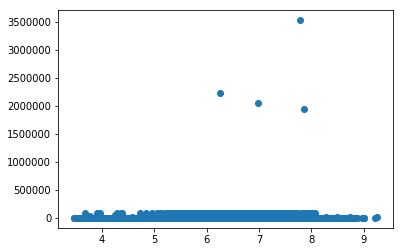

In [335]:
cooks_d2a, pvalsa = inf.cooks_distance
fox_cra = 4 / (len(filter_X['trip_duration']) - 2)
idxa = np.where(cooks_d2a > fox_cra)[0]

ax = plt.subplot()
plt.scatter(y_new,filter_X['trip_duration'])
plt.scatter(y_new[idxa], filter_X['trip_duration'][idxa], s=300, c="r", alpha=0.5)
utils.annotate_axes(range(len(idxa)), idx, 
                    list(zip(y_new[idxa], filter_X['trip_duration'][idxa])), [(-20, 15)] * len(idxa), size="small", ax=ax)
plt.show()
len(idxa)

In [ ]:
ax = plt.subplot()
plt.scatter(y_new,filter_X['trip_duration'])
sm.graphics.abline_plot(model_results=resulta, ax=ax)

idx = hat > 0.05
plt.scatter(y_new[idx], filter_X['trip_duration'][idx], s=300, c="r", alpha=0.5)
plt.show()

In [ ]:
ax = plt.subplot()
plt.scatter(y_new,filter_X['trip_duration'])
sm.graphics.abline_plot(model_results=resulta,c='r',ax=ax)

In [ ]:
sm.stats.anova_lm(resulta,typ =2)

In [ ]:
sp.stats.probplot(resulta.resid, plot=plt)
plt.show()

In [336]:
filter_X2 =train[:]
filter_X2.drop(idxa,0,inplace = True)
model = sm.OLS.from_formula(formulaIs1,data = filter_X2)
result = model.fit()
result.summary()

C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     I(np.log(trip_duration))   R-squared:                       0.679
Model:                                  OLS   Adj. R-squared:                  0.679
Method:                       Least Squares   F-statistic:                 6.271e+04
Date:                      Sun, 22 Oct 2017   Prob (F-statistic):               0.00
Time:                              14:14:47   Log-Likelihood:            -3.5290e+05
No. Observations:                    681481   AIC:                         7.059e+05
Df Residuals:                        681457   BIC:                         7.061e+05
Df Model:                                23                                         
Covariance Type:                  nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
C(pickup_Province)[Bronx]                 5.4378      0.037    146.597      0.000       5.365       5.511
C(pickup_Province)[Brooklyn]              5.2238      0.015    347.894      0.000       5.194       5.253
C(pickup_Province)[Manhattan]             5.3095      0.014    368.333      0.000       5.281       5.338
C(pickup_Province)[Queens]                5.1727      0.014    364.726      0.000       5.145       5.200
C(pickup_Province)[outward]               5.1870      0.048    107.960      0.000       5.093       5.281
C(dropoff_Province)[T.Brooklyn]           0.2601      0.008     33.011      0.000       0.245       0.276
C(dropoff_Province)[T.Manhattan]          0.3031      0.008     38.424      0.000       0.288       0.319
C(dropoff_Province)[T.Queens]             0.1681      0.008     20.775      0.000       0.152       0.184
C(dropoff_Province)[T.Staten Island]      0.0990      0.072      1.371      0.170      -0.043       0.240
C(dropoff_Province)[T.outward]            0.0306      0.013      2.376      0.017       0.005       0.056
C(pickup_dropoff_same_Province)[T.1]     -0.0199      0.003     -7.078      0.000      -0.025      -0.014
C(pickup_Airport)[T.L]                    0.1082      0.006     18.782      0.000       0.097       0.120
C(pickup_Airport)[T.N]                    0.0996      0.006     16.148      0.000       0.088       0.112
C(dropoff_Airport)[T.L]                   0.0901      0.011      8.306      0.000       0.069       0.111
C(dropoff_Airport)[T.N]                   0.1780      0.010     17.467      0.000       0.158       0.198
C(rest_day)[T.True]                      -0.1294      0.003    -44.246      0.000      -0.135      -0.124
C(weekend)[T.True]                       -0.0294      0.003     -8.903      0.000      -0.036      -0.023
C(vendor_id)[T.2]                         0.0022      0.001      2.184      0.029       0.000       0.004
C(store_and_fwd_flag)[T.Y]                0.0165      0.008      1.980      0.048       0.000       0.033
I(np.log(dummy_manhattan_dist + 0.1))    -0.4748      0.005    -86.617      0.000      -0.486      -0.464
I(np.log(distance + 0.1))                 1.2307      0.006    216.997      0.000       1.220       1.242
bearing                                   0.0002   4.93e-06     43.758      0.000       0.000       0.000
day_of_week                               0.0111      0.000     27.480      0.000       0.010       0.012
hr                                        0.0048    7.8e-05     61.107      0.000       0.005       0.005
==============================================================================
Omnibus:                     5095.030   Durbin-Watson:                   1.6

#### Dependent Variable
> * trip_duration
>  * 100000(sec) 이상의 값을 보이는 데이터가 4개 존재함

In [76]:
a = train['trip_duration'].count()
b = train['trip_duration'][train['trip_duration'] < 1500000].count()
c= train['trip_duration'][train['trip_duration'] < 40000].count()
print ("total : {}".format(a))
print ("Trip_duration <1500000 : {} , filter count {}".format(b,a-b))
print ("Trip_duration <40000 : {}, filter count {}".format(c,a-c))


total : 701778
Trip_duration <1500000 : 701774 , filter count 4
Trip_duration <40000 : 700836, filter count 942


In [8]:
train[:][train['trip_duration']/3600 >24]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,weekend,pickup_time_float,distance,dummy_manhattan_dist,bearing,speed_kmph,speed_kmph_dummy,pickup_Province,dropoff_Province,hour_day_of_week_float
460097,id0053347,1,2016-02-13 22:46:00,2016-03-25 18:18:00,1,-73.783905,40.648632,-73.978271,40.750202,N,...,True,22.766667,19.900661,27.691935,-55.358996,0.020317,0.028271,Queens,Manhattan,5.916667
460154,id0369307,1,2016-02-13 22:38:00,2016-03-08 15:57:00,2,-73.921677,40.735252,-73.984749,40.759979,N,...,True,22.633333,5.982487,8.063718,-62.618642,0.010508,0.014164,Queens,Manhattan,5.916667
682215,id1325766,1,2016-01-05 06:14:00,2016-01-31 01:01:00,1,-73.983788,40.742325,-73.985489,40.727676,N,...,False,6.233333,1.635128,1.772166,-174.969940,0.002642,0.002864,Manhattan,Manhattan,1.250000
682482,id1864733,1,2016-01-05 00:19:00,2016-01-27 11:08:00,1,-73.789650,40.643559,-73.956810,40.773087,N,...,False,0.316667,20.148665,28.506500,-44.316302,0.037394,0.052906,Queens,Manhattan,1.000000


In [15]:
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,year,month,day,...,Event,Visibility,pickup_time_float,distance,dummy_manhattan_dist,bearing,speed_kmph,speed_kmph_dummy,hour_day_of_week_float,log_trip_duration
count,701778.000000,701778.000000,701778.000000,701778.000000,701778.000000,701778.000000,7.017780e+05,701778.0,701778.000000,701778.000000,...,690496.000000,687645.000000,701778.000000,701778.000000,701778.000000,701778.000000,701778.000000,701778.000000,701778.000000,701778.000000
mean,1.536037,1.666577,-73.973665,40.750969,-73.973583,40.751836,9.387318e+02,2016.0,2.542780,15.538534,...,0.067830,15.069022,14.131203,3.397331,4.389819,-15.645382,14.560844,18.827956,3.647005,6.441720
std,0.498700,1.319466,0.043910,0.033139,0.044214,0.037572,6.772504e+03,0.0,1.111019,8.702017,...,0.301393,3.022923,6.384562,4.248709,5.680476,104.550119,14.361897,19.717187,1.942116,0.790094
min,1.000000,0.000000,-78.547401,34.359695,-79.817978,32.181141,1.000000e+00,2016.0,1.000000,1.000000,...,0.000000,0.400000,0.000000,0.000000,0.000000,-179.991119,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,-73.991829,40.737400,-73.991325,40.735959,3.900000e+02,2016.0,2.000000,8.000000,...,0.000000,16.100000,9.600000,1.221590,1.558700,-125.405469,9.272441,11.694839,1.916667,5.966147
50%,2.000000,1.000000,-73.981789,40.754150,-73.979828,40.754478,6.480000e+02,2016.0,3.000000,15.000000,...,0.000000,16.100000,14.833333,2.072920,2.661343,8.156021,12.898156,16.509446,3.750000,6.473891
75%,2.000000,2.000000,-73.967567,40.768246,-73.963249,40.769691,1.047000e+03,2016.0,4.000000,23.000000,...,0.000000,16.100000,19.466667,3.823712,4.937964,53.621323,17.971641,23.301186,5.375000,6.953684
max,2.000000,8.000000,-61.335529,43.486885,-61.335529,43.674000,3.526282e+06,2016.0,4.000000,31.000000,...,2.000000,16.100000,23.983333,891.214104,1282.539301,180.000000,6877.340405,9404.425383,6.958333,15.075755


,count,mean,std,min,25%,50%,75%,max
vendor_id,,,,,,,,
1,325599.0,6.425355,0.784136,0.0,5.961005,6.467699,6.947937,15.075755
2,376179.0,6.455885,0.794945,0.0,5.971262,6.480045,6.958448,11.366384


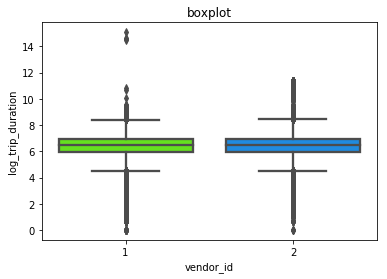

In [17]:
plt.ylabel('count of id')
plt.title('boxplot')
sns.boxplot(x = 'vendor_id', y = 'log_trip_duration',
            data = train, palette = 'gist_rainbow', linewidth = 2.3)
train.groupby('vendor_id')['log_trip_duration'].describe()

,count,mean,std,min,25%,50%,75%,max
month,,,,,,,,
1,165104.0,6.416178,0.785793,0.0,5.948035,6.444131,6.919684,14.616441
2,171599.0,6.419854,0.781575,0.0,5.950643,6.453625,6.930495,15.075755
3,184135.0,6.449878,0.789709,0.0,5.973810,6.483107,6.960348,11.366349
4,180940.0,6.477462,0.800854,0.0,5.998937,6.513230,6.998510,11.366326


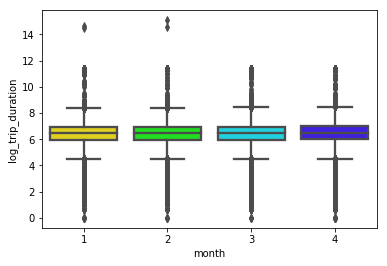

In [27]:
sns.boxplot(x = 'month', y = 'log_trip_duration', data = train, palette = 'gist_rainbow', linewidth = 2.3)
train.groupby('month')['log_trip_duration'].describe()

,count,mean,std,min,25%,50%,75%,max
day,,,,,,,,
1,22225.0,6.435930,0.787713,0.693147,5.966147,6.467699,6.954639,11.366199
2,23054.0,6.409581,0.777413,0.693147,5.948035,6.450470,6.922644,11.366303
3,22515.0,6.413800,0.804147,0.000000,5.926926,6.450470,6.935370,11.366118
4,23191.0,6.434033,0.788804,0.693147,5.953243,6.452049,6.945051,11.366210
5,24143.0,6.421993,0.789963,0.693147,5.945421,6.452049,6.930006,14.616441
6,23698.0,6.401910,0.778737,0.693147,5.937536,6.436150,6.908755,11.366106
7,22806.0,6.417350,0.773606,0.000000,5.953243,6.453625,6.917706,11.366326
8,23254.0,6.436787,0.778835,0.693147,5.963579,6.467699,6.946976,11.366095
9,24574.0,6.408253,0.766800,0.000000,5.951293,6.448889,6.903747,11.366349


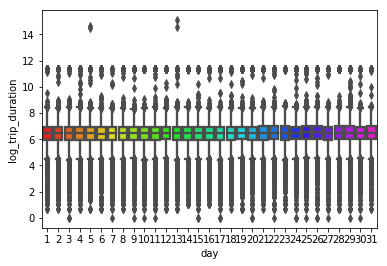

In [28]:
sns.boxplot(x = 'day', y = 'log_trip_duration', data = train, palette = 'gist_rainbow', linewidth = 2.3)
train.groupby('day')['log_trip_duration'].describe()

,count,mean,std,min,25%,50%,75%,max
hr,,,,,,,,
0,25191.0,6.401197,0.783323,0.000000,5.953243,6.456770,6.925595,14.478062
1,18339.0,6.358847,0.774727,0.693147,5.905362,6.406880,6.871091,11.364820
2,13439.0,6.318473,0.793467,0.693147,5.866468,6.381816,6.844815,11.366349
3,10025.0,6.318607,0.813348,0.693147,5.866468,6.388561,6.862758,11.365875
4,7486.0,6.321289,0.889140,0.000000,5.826000,6.401917,6.929272,11.365179
5,7080.0,6.237320,0.904383,0.000000,5.645447,6.246107,6.904751,11.365318
6,15665.0,6.174376,0.848950,0.693147,5.659482,6.148468,6.685861,14.616441
7,26728.0,6.330603,0.783214,0.693147,5.860786,6.336826,6.804615,11.365990
8,32183.0,6.439997,0.782398,0.693147,5.958425,6.470800,6.949856,11.366106


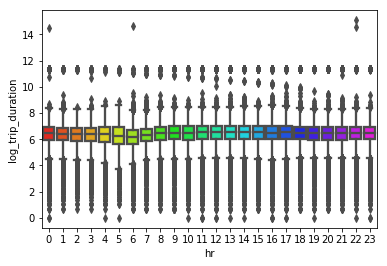

In [29]:
sns.boxplot(x = 'hr', y = 'log_trip_duration', data = train, palette = 'gist_rainbow', linewidth = 2.3)
train.groupby('hr')['log_trip_duration'].describe()

,count,mean,std,min,25%,50%,75%,max
day_of_week,,,,,,,,
0,88552.0,6.403712,0.793887,0.0,5.926926,6.421622,6.908755,11.366257
1,95208.0,6.466408,0.784488,0.0,5.988961,6.493754,6.979145,14.616441
2,99212.0,6.475882,0.784883,0.0,6.001415,6.508769,6.991177,11.366349
3,103534.0,6.500740,0.798292,0.0,6.023448,6.541030,7.020191,11.366118
4,112378.0,6.477106,0.793076,0.0,6.002033,6.513230,6.990257,11.366280
5,110500.0,6.400188,0.770226,0.0,5.942799,6.439350,6.901737,15.075755
6,92394.0,6.356519,0.796976,0.0,5.883322,6.386879,6.865891,11.366384


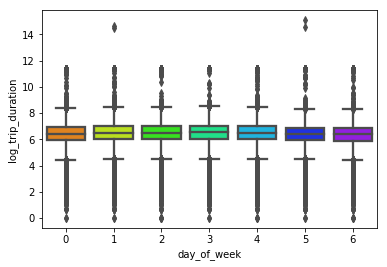

In [30]:
sns.boxplot(x = 'day_of_week', y = 'log_trip_duration', data = train, palette = 'gist_rainbow', linewidth = 2.3)
train.groupby('day_of_week')['log_trip_duration'].describe()

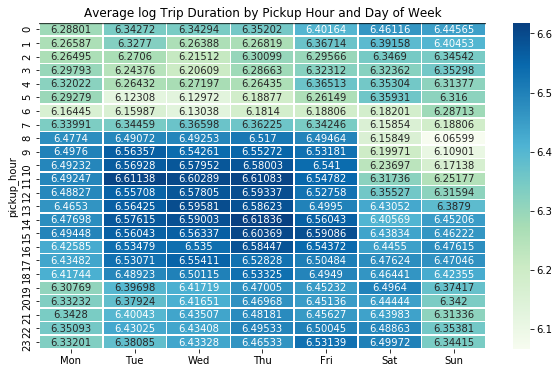

In [22]:
# Trips by Hour and Day of Week
plt.figure(figsize=(10,6))
pickup_speed = train.groupby(['hr','day_of_week'])['log_trip_duration'].mean().unstack()
hourday_graph = sns.heatmap(pickup_speed,
                                   lw = .5, annot = True, cmap = 'GnBu', fmt = 'g',annot_kws = {"size":10} )
# Customize tick label size
hourday_graph.tick_params(axis = 'both', which = 'major', labelsize = 10)

# Customize tick labels of the y-axis
hourday_graph.set_xticklabels(labels = ['Mon', 'Tue', 'Wed','Thu','Fri','Sat','Sun'])

# Bolding horizontal line at y = 0
hourday_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)

# Remove the label of the x-axis
hourday_graph.xaxis.label.set_visible(False)

# Add signature bar
plt.ylabel('pickup_hour')
plt.xlabel('pickup_weekday (Mon - Sun)')
plt.title('Average log Trip Duration by Pickup Hour and Day of Week')
plt.show()

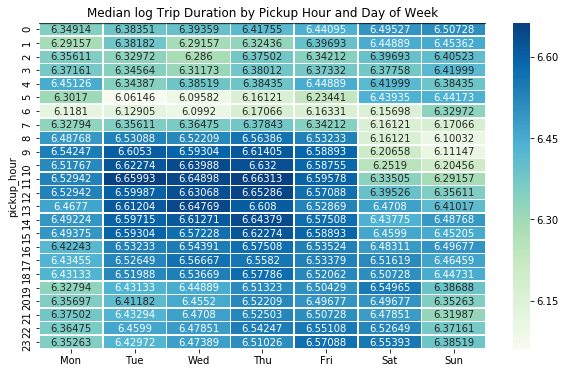

In [23]:
# Trips by Hour and Day of Week
plt.figure(figsize=(10,6))
pickup_hourday = train.groupby(['hr','day_of_week'])['log_trip_duration'].median().unstack()
hourday_graph = sns.heatmap(pickup_hourday,
                                   lw = .5, annot = True, cmap = 'GnBu', fmt = 'g',annot_kws = {"size":10} )
# Customize tick label size
hourday_graph.tick_params(axis = 'both', which = 'major', labelsize = 10)

# Customize tick labels of the y-axis
hourday_graph.set_xticklabels(labels = ['Mon', 'Tue', 'Wed','Thu','Fri','Sat','Sun'])

# Bolding horizontal line at y = 0
hourday_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)

# Remove the label of the x-axis
hourday_graph.xaxis.label.set_visible(False)

# Add signature bar
plt.ylabel('pickup_hour')
plt.xlabel('pickup_weekday (Mon - Sun)')
plt.title('Median log Trip Duration by Pickup Hour and Day of Week')
plt.show()

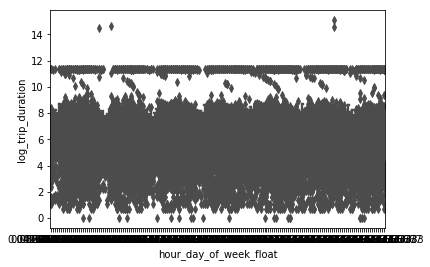

In [24]:
sns.boxplot(x = 'hour_day_of_week_float', y = 'log_trip_duration',
            data = train, palette = 'gist_rainbow', linewidth = 2.3)

,count,mean,std,min,25%,50%,75%,max
rest_day,,,,,,,,
False,476775.0,6.471995,0.790638,0.0,5.996452,6.504288,6.984716,14.616441
True,225003.0,6.377567,0.785094,0.0,5.910797,6.411818,6.884487,15.075755


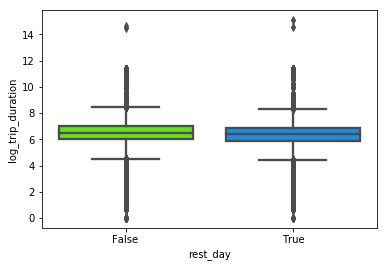

In [26]:
sns.boxplot(x = 'rest_day', y = 'log_trip_duration', data = train, 
                          palette = 'gist_rainbow', linewidth = 2.3)
train.groupby('rest_day')['log_trip_duration'].describe()

,count,mean,std,min,25%,50%,75%,max
weekend,,,,,,,,
False,498884.0,6.466698,0.791672,0.0,5.988961,6.498282,6.980076,14.616441
True,202894.0,6.380302,0.782821,0.0,5.916202,6.415097,6.886532,15.075755


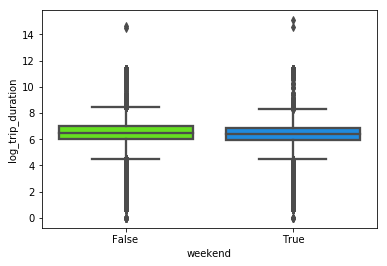

In [31]:
sns.boxplot(x = 'weekend', y = 'log_trip_duration', data = train, 
                          palette = 'gist_rainbow', linewidth = 2.3)
train.groupby('weekend')['log_trip_duration'].describe()

,count,mean,std,min,25%,50%,75%,max
passenger_count,,,,,,,,
0,31.0,3.769731,2.376877,0.693147,1.777674,3.091042,5.844908,8.084254
1,497800.0,6.425975,0.795172,0.000000,5.953243,6.463029,6.942157,15.075755
2,100422.0,6.491827,0.774310,0.000000,6.013715,6.514713,6.995766,14.533144
3,28321.0,6.480887,0.761514,0.693147,6.013715,6.501290,6.972606,11.365944
4,13568.0,6.505234,0.772903,1.386294,6.021023,6.527958,7.012115,11.366349
5,38131.0,6.461897,0.782499,0.693147,5.978886,6.483107,6.958448,11.366280
6,23503.0,6.448238,0.781360,1.098612,5.962292,6.472346,6.950815,11.366210
7,1.0,3.218876,NaN,3.218876,3.218876,3.218876,3.218876,3.218876
8,1.0,4.644391,NaN,4.644391,4.644391,4.644391,4.644391,4.644391


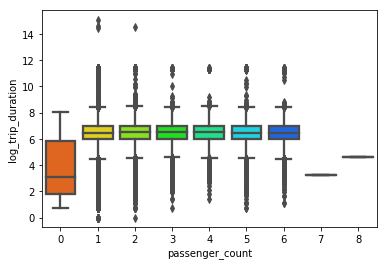

In [32]:
sns.boxplot(x = 'passenger_count', y = 'log_trip_duration', data = train, 
                          palette = 'gist_rainbow', linewidth = 2.3)
train.groupby('passenger_count')['log_trip_duration'].describe()

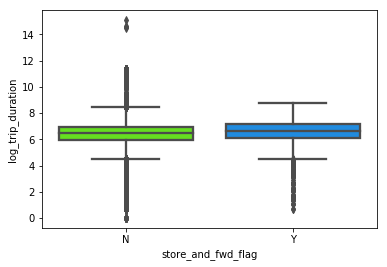

In [33]:
sns.boxplot(x = 'store_and_fwd_flag', y = 'log_trip_duration', data = train, 
                          palette = 'gist_rainbow', linewidth = 2.3)

In [59]:
import statsmodels.api as sm
corr_train = train.corr()

C:\Users\pc\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


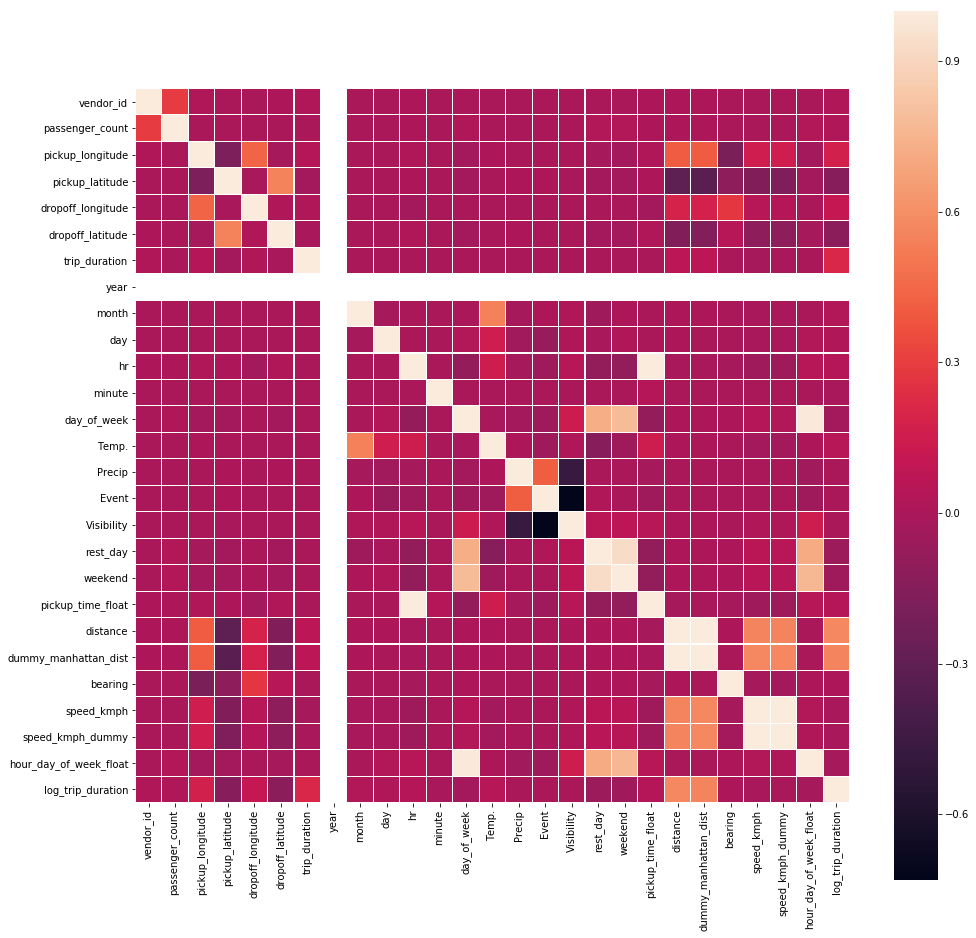

In [55]:
plt.figure(figsize=(16,16))
sns.heatmap(corr_train,lw=.1, square = True)

In [56]:
corr_train['trip_duration']

vendor_id                 0.013965
passenger_count           0.004983
pickup_longitude          0.033846
pickup_latitude          -0.022893
dropoff_longitude         0.017076
dropoff_latitude         -0.013921
trip_duration             1.000000
year                           NaN
month                     0.001487
day                       0.001084
hr                        0.002551
minute                   -0.001956
day_of_week              -0.000255
Temp.                     0.000474
Precip                   -0.000769
Event                     0.000178
Visibility                0.000677
rest_day                 -0.002622
weekend                  -0.002051
pickup_time_float         0.002461
distance                  0.071832
dummy_manhattan_dist      0.070555
bearing                  -0.000152
speed_kmph               -0.014788
speed_kmph_dummy         -0.014012
hour_day_of_week_float    0.000094
log_trip_duration         0.201808
Name: trip_duration, dtype: float64

In [57]:
corr_train['log_trip_duration']

vendor_id                 0.019270
passenger_count           0.018767
pickup_longitude          0.173413
pickup_latitude          -0.141008
dropoff_longitude         0.113170
dropoff_latitude         -0.116202
trip_duration             0.201808
year                           NaN
month                     0.030280
day                       0.022227
hr                        0.037914
minute                   -0.008411
day_of_week              -0.024844
Temp.                     0.048177
Precip                   -0.006330
Event                    -0.002220
Visibility               -0.000366
rest_day                 -0.055780
weekend                  -0.049574
pickup_time_float         0.037502
distance                  0.570943
dummy_manhattan_dist      0.553652
bearing                   0.006024
speed_kmph               -0.008301
speed_kmph_dummy         -0.011721
hour_day_of_week_float   -0.019709
log_trip_duration         1.000000
Name: log_trip_duration, dtype: float64

In [131]:
sample_df = filter_X[:][(train['passenger_count']!=0)]
sample_df = sample_df[:][(sample_df['dummy_manhattan_dist']!=0)]
sample_df = sample_df[:][(sample_df['speed_kmph_dummy']<150)]
sample_df = sample_df[:][(sample_df['trip_duration']<36000)]
#filter_X = filter_X[:][(filter_X['dummy_manhattan_dist']!=0)]
#sample_df = sample_df[:][(sample_df['pickup_Province'] =='Manhattan') & (sample_df['dropoff_Province'] =='Manhattan')]
model = sm.OLS.from_formula('np.log(trip_duration) ~ scale(np.log(dummy_manhattan_dist))+scale(bearing) +C(pickup_Province)+C(dropoff_Province)+passenger_count+C(pickup_dropoff_same_Province) + C(pickup_Airport)+C(dropoff_Airport)+C(rest_day)+C(hour_day_of_week_float)+0',
                            data =sample_df)
result = model.fit()
print (result.summary())

C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


                              OLS Regression Results                             
Dep. Variable:     np.log(trip_duration)   R-squared:                       0.675
Model:                               OLS   Adj. R-squared:                  0.675
Method:                    Least Squares   F-statistic:                     7789.
Date:                   Sat, 21 Oct 2017   Prob (F-statistic):               0.00
Time:                           06:51:59   Log-Likelihood:            -4.0347e+05
No. Observations:                 697849   AIC:                         8.073e+05
Df Residuals:                     697662   BIC:                         8.094e+05
Df Model:                            186                                         
Covariance Type:               nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

In [158]:
train['Visibility'].describe()

count    687645.000000
mean         15.069022
std           3.022923
min           0.400000
25%          16.100000
50%          16.100000
75%          16.100000
max          16.100000
Name: Visibility, dtype: float64

In [86]:
print (result.summary())

                               OLS Regression Results                               
Dep. Variable:     I(np.log(trip_duration))   R-squared:                       0.392
Model:                                  OLS   Adj. R-squared:                  0.392
Method:                       Least Squares   F-statistic:                     2423.
Date:                      Fri, 20 Oct 2017   Prob (F-statistic):               0.00
Time:                              12:46:00   Log-Likelihood:            -6.4282e+05
No. Observations:                    687645   AIC:                         1.286e+06
Df Residuals:                        687461   BIC:                         1.288e+06
Df Model:                               183                                         
Covariance Type:                  nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

In [78]:
x = ['distance','Event','hour_day_of_week_float','pickup_Province','dropoff_Province']

In [79]:
m1 = result.predict(train[x])

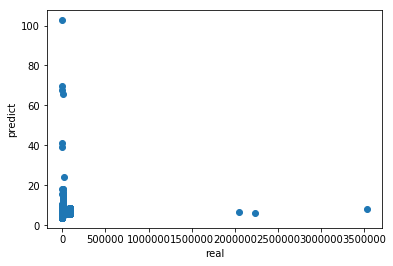

In [81]:
plt.scatter(train['trip_duration'], m1)
plt.xlabel('real')
plt.ylabel('predict')
plt.show()

In [82]:
sm.stats.anova_lm(result, typ=2)

,sum_sq,df,F,PR(>F)
C(Event),13278.055395,3.0,11301.755915,0.0
C(hour_day_of_week_float),15055.591247,167.0,230.204626,0.0
C(pickup_Province),2034.934373,5.0,1039.233423,0.0
C(dropoff_Province),3925.084498,5.0,2004.526067,0.0
distance,100007.769108,1.0,255367.980294,0.0
Residual,270342.675901,690315.0,NaN,NaN


In [225]:
train['Event'].value_counts().sum()

690496